In [135]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **P P2. Clasificación**

**1.** Primero, se importan los datos de entrenamiento y prueba al ambiente de trabajo utilizando la librería pandas.

A continuación, se exploran las características de la base de datos imprimiendo primero un resumen de la base, después el tipo de datos, qué variables son cualitativas y cuales cuantitativas y cuántas son de cada una, y el porcentaje de huecos en cada variable.

In [136]:
import pandas as pd

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

combine = [df, df_test]

print("Resumen del dataframe:")
print(df.head())

print("\nTipos de datos:")
print(df.dtypes)

qualitative = []
quantitative = []

for col in df.columns:
  if df[col].dtype == 'object' or df[col].dtype == 'bool':
    qualitative.append(col)
  elif pd.api.types.is_numeric_dtype(df[col]):
    quantitative.append(col)

print(f"Número total de variables: {df.shape[1]}")
print("\nVariables cualitativas:")
print(qualitative)

print("\nVariables cuantitativas:")
print(quantitative)

missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_values_test = df_test.isnull().sum()
missing_percent_test = (missing_values_test / len(df_test)) * 100

missing_df = pd.DataFrame({
    'Huecos': missing_values,
    'Porcentaje (%)': missing_percent
})

missing_df_test = pd.DataFrame({
    'Huecos': missing_values_test,
    'Porcentaje (%)': missing_percent_test
})

print("\ntrain:")
print(missing_df[missing_df['Huecos'] > 0].sort_values(by='Huecos', ascending=False))

print("\ntest:")
print(missing_df_test[missing_df_test['Huecos'] > 0].sort_values(by='Huecos', ascending=False))

Resumen del dataframe:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        Fals

# **Relleno de Huecos**

Para limpiar la base de datos en cuanto a huecos, a continuación se rellenan los huecos utilizando la media para variables cuantitativas y la moda para variables cualitativas.
Estos cambios se realizan tanto en los datos de entrenamiento como en los de prueba, para rellenar huecos en ambos datasets. Para esto se crea una variable combine que incluya ambos datasets y se modifican ambos al mismo tiempo.

In [137]:
group_mode_cols = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP']

group_median_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for dataset in combine:
  for col in group_mode_cols:
    dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

  for col in group_median_cols:
    dataset[col] = dataset[col].fillna(dataset[col].median())

print("Huecos en variables:")
print(df.isnull().sum())

Huecos en variables:
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64


# **Feature Engineering**

Para mejorar el nivel de predicción del modelo, se utilizan algunos métodos de feature engineering en las variables.

Primero, en la variable 'Cabin', se separan 3 variables apartir de la división con / que existe en los datos. De esta variable se extraen 'CabinDeck', 'CabinNum' y 'CabinSide'. Una vez extraídas, se mapean de letras a números los datos de 'CabinDeck' y de 'CabinSide'.

In [138]:
for dataset in combine:
  dataset['Cabin'] = dataset['Cabin'].fillna('Unknown/0/U')

  dataset[['CabinDeck', 'CabinNum', 'CabinSide']] = dataset['Cabin'].str.split('/', expand=True)

  dataset['CabinNum'] = pd.to_numeric(dataset['CabinNum'], errors='coerce')

deck_mapping = {"B": 1, "C": 1, "G": 2,"Unknown": 2, "A": 2, "F": 3, "D": 3, "E": 4, "T": 5}
for dataset in combine:
    dataset['CabinDeck'] = dataset['CabinDeck'].map(deck_mapping)

side_map = {'P':1,'S':0}
for dataset in combine:
    dataset['CabinSide'] = dataset['CabinSide'].map(side_map)
for dataset in combine:
    dataset['CabinSide'].fillna(dataset['CabinSide'].mode()[0],inplace=True)

Para la variable 'Age' se generan intervalos de edades utilizando la función cut de pandas y se dividen en 5 grupos denominados 0, 1, 2, 3 y 4 los cuales son parte de una nueva variable llamada AgeBin.

In [139]:
for dataset in combine:
  dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
for dataset in combine:
  dataset.loc[dataset['Age'] <= 15, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 15) & (dataset['Age'] <= 31), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 31) & (dataset['Age'] <= 47), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 47) & (dataset['Age'] <= 63), 'Age'] = 3
  dataset.loc[(dataset['Age'] > 63), 'Age'] = 4
  dataset['Age'] = dataset['Age'].astype(int)

Se crea una varibale llamada 'TotalSpent' la cual incluye todas las variables que incluyen datos sobre gastos económicos para juntarlos en una sola variable.

In [140]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for dataset in combine:
  dataset['TotalSpent'] = dataset[spending_cols].sum(axis=1)

Una vez obtenido 'TotalSpent', se generan variables nuevas para cada variable de gasto y en lugar de la cantidad total se guarda la proporción del total que representa.

In [141]:
for dataset in combine:
    dataset['vr'] = dataset['VRDeck'] / dataset['TotalSpent']
    dataset['spa'] = dataset['Spa'] / dataset['TotalSpent']
    dataset['room'] = dataset['RoomService'] / dataset['TotalSpent']
    dataset['shop'] = dataset['ShoppingMall'] / dataset['TotalSpent']
    dataset['food'] = dataset['FoodCourt'] / dataset['TotalSpent']

for dataset in combine:
    dataset['vr'].fillna(0,inplace = True)
    dataset['spa'].fillna(0,inplace = True)
    dataset['room'].fillna(0,inplace = True)
    dataset['shop'].fillna(0,inplace = True)
    dataset['food'].fillna(0,inplace = True)

La variable 'CabinNum' se mapea a variables que describen si pertenece a una de 7 regiones diferentes. Además se crea la variable 'group' que se extrae de la primera parte de la variable original 'PassengerId' antes del "_".

In [142]:
for dataset in combine:
  dataset['region1']=(dataset['CabinNum']<300).astype(int)
  dataset['region2']=((dataset['CabinNum']>=300)& (dataset['CabinNum']<600)).astype(int)
  dataset['region3']=((dataset['CabinNum']>=600)& (dataset['CabinNum']<900)).astype(int)
  dataset['region4']=((dataset['CabinNum']>=900)& (dataset['CabinNum']<1200)).astype(int)
  dataset['region5']=((dataset['CabinNum']>=1200)& (dataset['CabinNum']<1500)).astype(int)
  dataset['region6']=((dataset['CabinNum']>=1500)& (dataset['CabinNum']<1800)).astype(int)
  dataset['region7']=(dataset['CabinNum']>1800).astype(int)

for dataset in combine:
  dataset['group'] = dataset.PassengerId.apply(lambda x:x.split('_')[0])
  dataset['group'] = dataset['group'].astype(int)

Los métodos de feature engineering fueron tomados de la solución del ususario [PRISCA CHANG](https://www.kaggle.com/code/priscachang/spaceship-titanic-complete-solutions-0-80593#Best-score)

# **Preparación de Datos**

Una vez teniendo las variables ajustadas, se debe preparar el formato y filtrar las variables para empezar a generar modelos de clasificación.

Se borran del dataset todas las variables descriptivas que no tienen poder predictivo o de las cuales ya derivaron nuevas variables, como lo son 'Name', 'Cabin', 'PassengerId', 'AgeBin', 'CabinNum', 'Age', 'RoomService', 'FoodCourt','ShoppingMall','Spa' y'VRDeck'.

Inmediatamente después, se utiliza la función get_dummies para transformar todas las variables categóricas a variables booleanas. Y utilizando la función MinMaxScaler se normalizan las variales cuantitativas.

Por último, se dividen los datos en entrenamiento y prueba con la función train_test_split con proporción 80/20.

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

drop_cols = ['Name', 'Cabin', 'PassengerId', 'AgeBin', 'CabinNum','Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df_model = df.drop(columns=drop_cols, errors='ignore')
df_test = df_test.drop(columns=drop_cols, errors='ignore')

categorical_cols = ['HomePlanet', 'Destination', 'CryoSleep', 'CabinDeck', 'CabinSide']
df_model = pd.get_dummies(df_model, columns=categorical_cols)
df_model = pd.get_dummies(df_model, columns=['VIP'], drop_first=True)

df_test = pd.get_dummies(df_test, columns=categorical_cols)
df_test = pd.get_dummies(df_test, columns=['VIP'], drop_first=True)

numeric_cols = ['TotalSpent']

scaler = MinMaxScaler()
df_model[numeric_cols] = scaler.fit_transform(df_model[numeric_cols])
df_test[numeric_cols] = scaler.fit_transform(df_test[numeric_cols])

X = df_model.drop('Transported', axis=1)
y = df_model['Transported']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Variables finales:")
for col in X_train.columns:
    print(col)

Variables finales:
TotalSpent
vr
spa
room
shop
food
region1
region2
region3
region4
region5
region6
region7
group
HomePlanet_Earth
HomePlanet_Europa
HomePlanet_Mars
Destination_55 Cancri e
Destination_PSO J318.5-22
Destination_TRAPPIST-1e
CryoSleep_False
CryoSleep_True
CabinDeck_1
CabinDeck_2
CabinDeck_3
CabinDeck_4
CabinDeck_5
CabinSide_0.0
CabinSide_1.0
VIP_True


# **Modelos**

**2.** Primero, se entrena un modelo de regresión logística multinomial utilizando la función LogisticRegression con el parámetro multi_class = 'multinomial'. Una vez generado, se prueba su calidad utilizando validación cruzada k-fold con k=5 midiendo el accuracy y obteniendo la media.

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')

print("Logistic Regression Accuracy (5-fold):")
print(log_reg_scores)
lg_mean = np.mean(log_reg_scores)
print(f"Mean accuracy: {lg_mean:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression Accuracy (5-fold):
[0.78360891 0.78864127 0.77282531 0.80517613 0.79856115]
Mean accuracy: 0.7898


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**3.** Después se genera un modelo de LDA e igualmente se realiza un proceso de validación cruzada k-fold, k = 5, midiendo el accuracy y obteniendo la media.

In [125]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

lda_scores = cross_val_score(lda, X_train, y_train, cv=5, scoring='accuracy')

print("LDA Accuracy (5-fold):")
print(lda_scores)
lda_mean = np.mean(lda_scores)
print(f"Mean accuracy: {lda_mean:.4f}")

LDA Accuracy (5-fold):
[0.77857656 0.79726815 0.76779295 0.80086269 0.80719424]
Mean accuracy: 0.7903


**4.** El siguiente modelo es un modelo de árbol de decisión. Igual que los anteriores, se evalua mediante CV k-fold 5, midiendo el accuracy y obteniendo la media.

In [126]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)

tree_scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')

print("Decision Tree Accuracy (5-fold):")
print(tree_scores)
dt_mean = np.mean(tree_scores)
print(f"Mean accuracy: {dt_mean:.4f}")

Decision Tree Accuracy (5-fold):
[0.73903666 0.73687994 0.77066858 0.7620417  0.73381295]
Mean accuracy: 0.7485


**5.** Por último, se genera un modelo de Random Forests con la función RandomForestClassifier y se evalua con CV k-fold 5, midiendo el accuracy y obteniendo la media.

In [127]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

print("Random Forest Accuracy (5-fold):")
print(rf_scores)
rf_mean = np.mean(rf_scores)
print(f"Mean accuracy: {rf_mean:.4f}")

Random Forest Accuracy (5-fold):
[0.78073329 0.78648454 0.80517613 0.79439252 0.79352518]
Mean accuracy: 0.7921


Para comparar los 4 modelos, se genera un dataframe con el nombre de cada modelo y la media de los valores de accuracy obtenidos.

In [128]:
models = pd.DataFrame({
    'Model': ['Regresión Logística Multinomial', 'LDA', 'Árbol de Decisión',
              'Random Forest'],
    'Score': [lg_mean, lda_mean, dt_mean,
              rf_mean]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,0.792062
1,LDA,0.790339
0,Regresión Logística Multinomial,0.789763
2,Árbol de Decisión,0.748488


Como se puede observar, el modelo más completo y con el cual se obtienen mejores resultados es el modelo de Random Forest, después LDA lo cual indica que los datos son linealmente separables. En antepenúltimo lugar esta la regresión logística multinomial y en último el árbol de decisión lo cual se puede deber a el sobreajuste del modelo ya que no se utilizó ningún tipo de restricción en el modelo.

**6.** Para realizar las predicciones finales, se decidió utilizar un ensamble de los 4 modelos generados previamente. Para esto se utilizó la función VotingClassifier (ChatGPT) utilizando de estimadores los 4 modelos generados con algunas restricciones en los modelos de árbol de decisión y random forests. Una vez hecho el ensamble. Se mide la media de su accuracy mediante validación cruzada k-fold 5.

In [129]:
from sklearn.ensemble import VotingClassifier

log_final = LogisticRegression(C=10, multi_class='multinomial', solver='lbfgs', max_iter=1000)
lda_final = LinearDiscriminantAnalysis()
rf_final = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, random_state=42)
tree_final = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=1, random_state=42)

ensemble = VotingClassifier(
    estimators=[
        ('logreg', log_final),
        ('lda', lda_final),
        ('rf', rf_final),
        ('tree', tree_final)
    ],
    voting='soft'
)

ensemble_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='accuracy')

print("Ensemble VotingClassifier Accuracy (5-fold):")
print(ensemble_scores)
print(f"Mean accuracy: {np.mean(ensemble_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Ensemble VotingClassifier Accuracy (5-fold):
[0.78792236 0.80805176 0.78864127 0.80445723 0.80503597]
Mean accuracy: 0.7988


Para preparar las predicciones, se entrena el modelo con los datos de entrenamiento, después se utilizan los datos de test para generar las predicciones y se guardan en la variable y_hats.

Por último se utiliza la función DataFrame y to_csv y se genera un archivo csv con base a la plantilla de submisiones para generar el archivo a subir.

In [130]:
preds_class = ensemble.fit(X_train, y_train)
x_test_final = df_test.copy()
y_hats = ensemble.predict(x_test_final)
y_hats = y_hats.T
print(y_hats)

test_df = pd.read_csv('sample_submission.csv')
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': y_hats
})
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[ True False  True ...  True  True  True]


Score Obtenido:

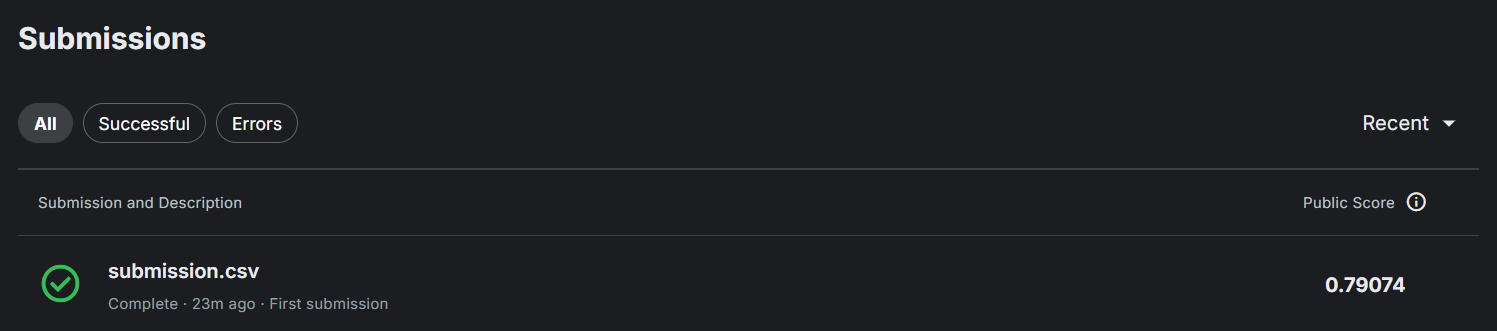

ChatGPT fue utilizado para proporcionar explicaciones y ejemplos de como usar algunas funciones.

Referencias:

[Ejemplo de Solución de Prisca Chang](https://www.kaggle.com/code/priscachang/spaceship-titanic-complete-solutions-0-80593#Best-score)

[ChatGPT, OpenAI](https://chat.openai.com/)